In [15]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


In [16]:
from PIL import Image

In [20]:
face=np.array(Image.open("lena.jpg").convert("L"))
face=face/255.

In [21]:
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

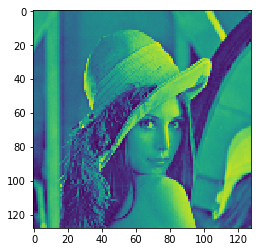

In [22]:
plt.imshow(face)
plt.show()

In [23]:
distorted=face.copy()
distorted[:,width//2:]+=0.075*np.random.randn(height,width//2)

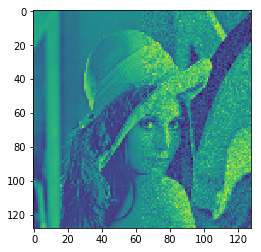

In [24]:
plt.imshow(distorted)

In [85]:
patch_size=(7,7)
data=extract_patches_2d(distorted[:,width//2:],patch_size)

/Users/hikaruasano/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


In [86]:
data=data.reshape(data.shape[0],-1)

In [87]:
data-=np.mean(data,axis=0)

In [88]:
data/=np.std(data,axis=0)

In [89]:
data.shape

(7076, 49)

In [90]:
dico=MiniBatchDictionaryLearning(n_components=100,alpha=1,n_iter=500)

In [91]:
V=dico.fit(data).components_

In [92]:
plt.figure(figsize=(8.4,8))

<Figure size 840x800 with 0 Axes>

<Figure size 840x800 with 0 Axes>

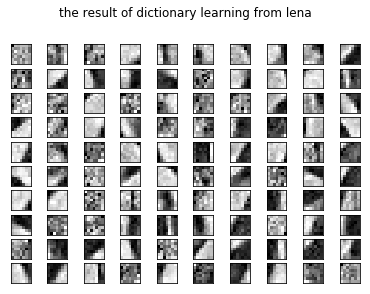

In [93]:
for i,comp in enumerate(V[:100]):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape(patch_size),cmap=plt.cm.gray_r,interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle("the result of dictionary learning from lena")
    plt.subplots_adjust(0.08,0.02,0.92,0.85,0.08,0.23)

Extracting noisy patches... 
done in 0.00s.
Orthogonal Matching Pursuit
1 atom...
/Users/hikaruasano/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides
done in 0.46s.
Orthogonal Matching Pursuit
2 atoms...
done in 0.83s.
Least-angle regression
5 atoms...
done in 4.61s.
Thresholding
 alpha=0.1...
done in 0.06s.


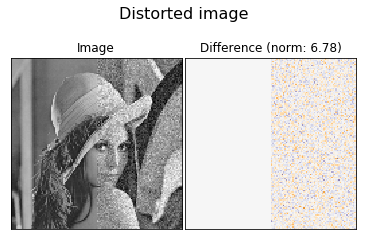

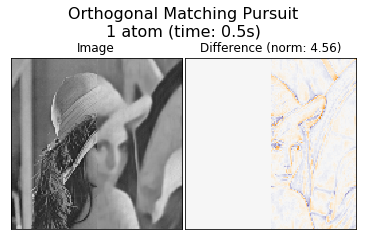

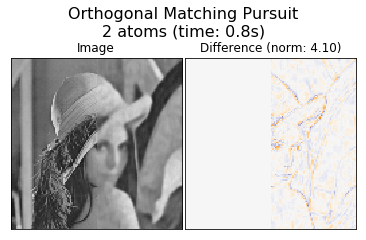

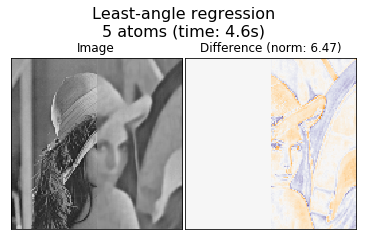

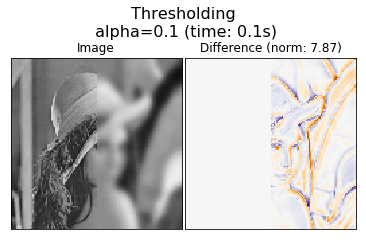

In [94]:
def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))
transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()